## Example with several HodoscopeDetectorLayers's

In [1]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from typing import List
from torch import Tensor, nn 
import torch
from tomopt.core import DEVICE
from tomopt.volume.layer import PassiveLayer 
from tomopt.volume import Volume
from torch import autograd

import numpy as np

In [2]:
init_xyz_span, xyz_gap = [1., 1., .3], [.1, .1, .1]
init_eff, init_res = 0.90, 1e4

In [3]:
def get_hods() -> List[Hodoscope]:
    hod_above = [
        Hodoscope(init_xyz= [1.25, 0.25, 0.5], 
                        init_xyz_span = init_xyz_span, 
                        xyz_gap = xyz_gap, 
                        eff = init_eff,
                        res = init_res,
                        smooth=.1,
                        ), 
                        # Hodoscope(init_xyz= [2., 0.5, .99], 
                        # init_xyz_span = init_xyz_span, 
                        # xyz_gap = xyz_gap, 
                        # eff = init_eff,
                        # res = init_res,
                        # smooth=.1,
                        # )
                        ]
    hod_above_2 = [
                        Hodoscope(init_xyz= [0., 0.25, 1.], 
                        init_xyz_span = init_xyz_span, 
                        xyz_gap = xyz_gap, 
                        eff = init_eff,
                        res = init_res,
                        smooth=.1,
                        ),
                        # Hodoscope(init_xyz= [1.5, 0.5, .99], 
                        # init_xyz_span = init_xyz_span, 
                        # xyz_gap = xyz_gap, 
                        # eff = init_eff,
                        # res = init_res,
                        # smooth=.1,
                        # ),
                        # Hodoscope(init_xyz= [2.5, 0.5, .98], 
                        # init_xyz_span = init_xyz_span, 
                        # xyz_gap = xyz_gap, 
                        # eff = init_eff,
                        # res = init_res,
                        # smooth=.1,
                        # ) 
                        ]


    hod_below = [
        Hodoscope(init_xyz= [1.25, 0.25, -1.], 
                        init_xyz_span = init_xyz_span, 
                        xyz_gap = xyz_gap, 
                        eff = init_eff,
                        res = init_res,
                        smooth=.1,
                        ), 
                        # Hodoscope(init_xyz= [2., 0.5, -1.01], 
                        # init_xyz_span = init_xyz_span, 
                        # xyz_gap = xyz_gap, 
                        # eff = init_eff,
                        # res = init_res,
                        # smooth=.1,
                        # )
                        ]
    hod_below_2 = [
                        Hodoscope(init_xyz= [0., 0.25, -1.5], 
                        init_xyz_span = init_xyz_span, 
                        xyz_gap = xyz_gap, 
                        eff = init_eff,
                        res = init_res,
                        smooth=.1,
                        ),
                        # Hodoscope(init_xyz= [1.5, 0.5, -1.51], 
                        # init_xyz_span = init_xyz_span, 
                        # xyz_gap = xyz_gap, 
                        # eff = init_eff,
                        # res = init_res,
                        # smooth=.1,
                        # ),
                        # Hodoscope(init_xyz= [2.5, 0.5, -1.52], 
                        # init_xyz_span = init_xyz_span, 
                        # xyz_gap = xyz_gap, 
                        # eff = init_eff,
                        # res = init_res,
                        # smooth=.1,
                        # ) 
                        ]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([3,1.5]), 
                                                z = .5, size = .5, 
                                                hodoscopes = hod_above)
    hod_detector_above_2 = HodoscopeDetectorLayer(pos = 'above', 
                                            lw = Tensor([3,1.5]), 
                                            z = 1., size = .5, 
                                            hodoscopes = hod_above_2)


    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([3,1.5]), 
                                                z = -1., size = .5, 
                                                hodoscopes = hod_below)
    hod_detector_below_2 = HodoscopeDetectorLayer(pos = 'below', 
                                            lw = Tensor([3,1.5]), 
                                            z = -1.5, size = .5, 
                                            hodoscopes = hod_below_2)
    
    return [hod_detector_above, hod_detector_above_2, hod_detector_below, hod_detector_below_2]

In [10]:
def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1.,0.5,1])
        size = 0.1
        layers.append(hod_layers[1])
        layers.append(hod_layers[0])
        for z in np.arange(0.,-.5, -0.1):
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[2])
        layers.append(hod_layers[3])

        return nn.ModuleList(layers)


In [11]:
volume = Volume(get_layers(get_hods()))

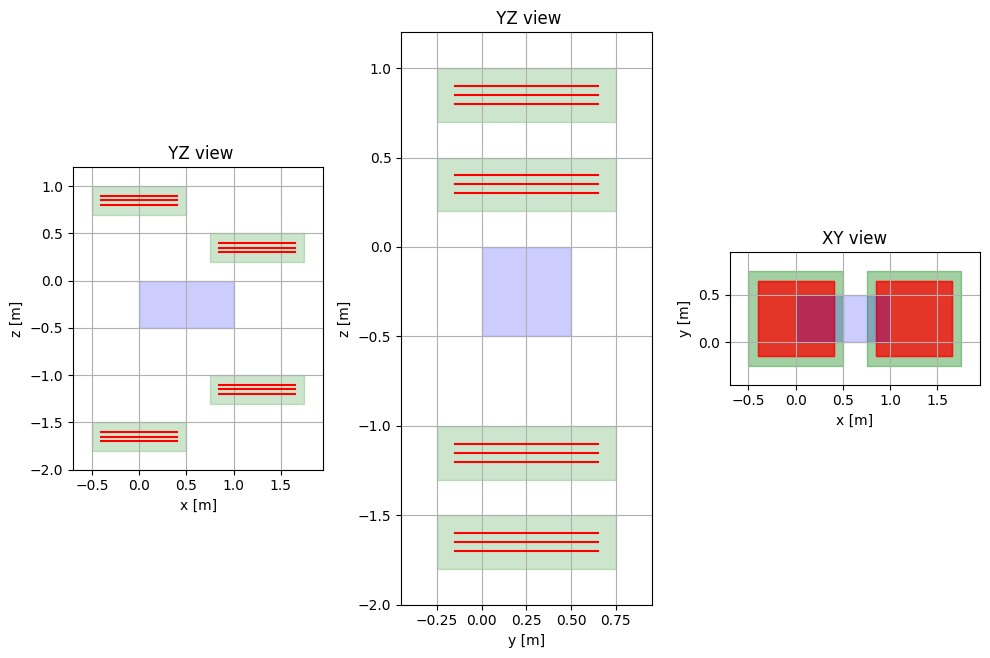

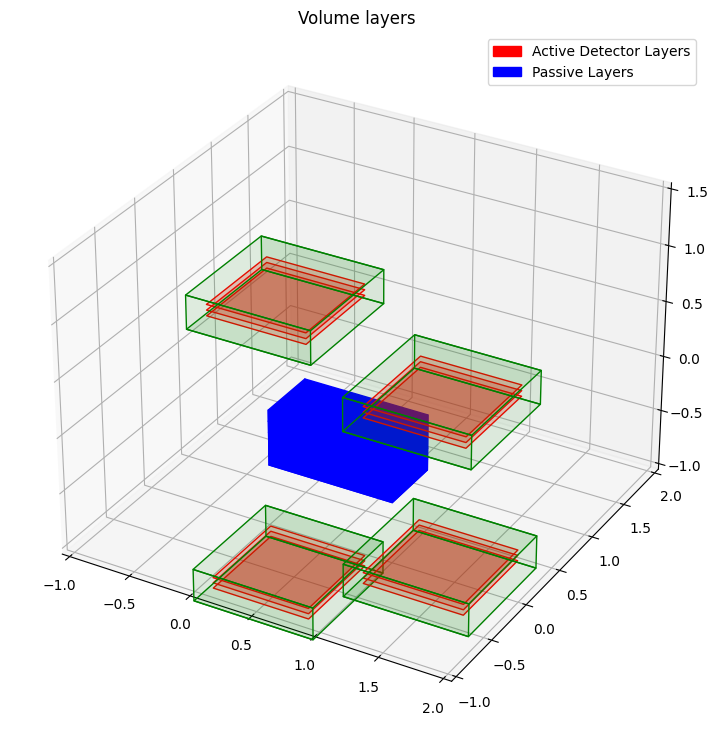

In [12]:
from plotting.plotting import draw_volume_2D, draw
draw_volume_2D(volume)
draw(volume, [-1.,2.], [-1., 2.], [-1.,1.5])

In [13]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume import Volume

from tomopt.core import X0
from torch import Tensor

from functools import partial
from tomopt.optimisation import VoxelX0Loss, ArbVolumeWrapper
from tomopt.inference import AbsX0Inferrer

from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=(partial(torch.optim.SGD, lr=5e4)),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=None, cost_coef=None))

In [14]:
from tomopt.core import X0
from torch import Tensor

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['air']
    #if z >= 0.4 and z <= 0.5: rad_length[:3,:3] = X0['lead']
    rad_length[:5, :] = X0['lead']
    rad_length[5:, :] = X0['iron']
    return rad_length


def arb_rad_length_cargo(*,z:float, lw:Tensor, size:float) -> Tensor:
    # empty cargo
    rad_length = torch.ones(list((lw/size).long()))*0.5925
    # Bottom layer made of steel
    if  z <= -.4: rad_length[:,:] = X0['steel']
    if  z > -0.1: rad_length[:,:] = X0['steel']
    # left wall
    rad_length[0:1,:] = X0['steel']
    # right wall
    rad_length[-1:,:] = X0['steel']
    # front
    rad_length[:,0:1] = X0['steel']
    # back
    rad_length[:,-1:] = X0['steel']

    if  z <= -0.6 and  z > -0.8: rad_length[1:2,8:9] = X0['uranium']
    
    #rad_length = torch.ones(list((lw/size).long()))*X0['steel']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length_cargo,arb_rad_length_cargo], shuffle=True)

In [15]:
from tomopt.optimisation.callbacks import MuonResampler, ScatterRecord, HitRecord
from tomopt.optimisation import PredHandler, ScatterRecord, HitRecord

sr = ScatterRecord()
hr = HitRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length_cargo]), 
                        n_mu_per_volume=100000, 
                        mu_bs=500, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr])

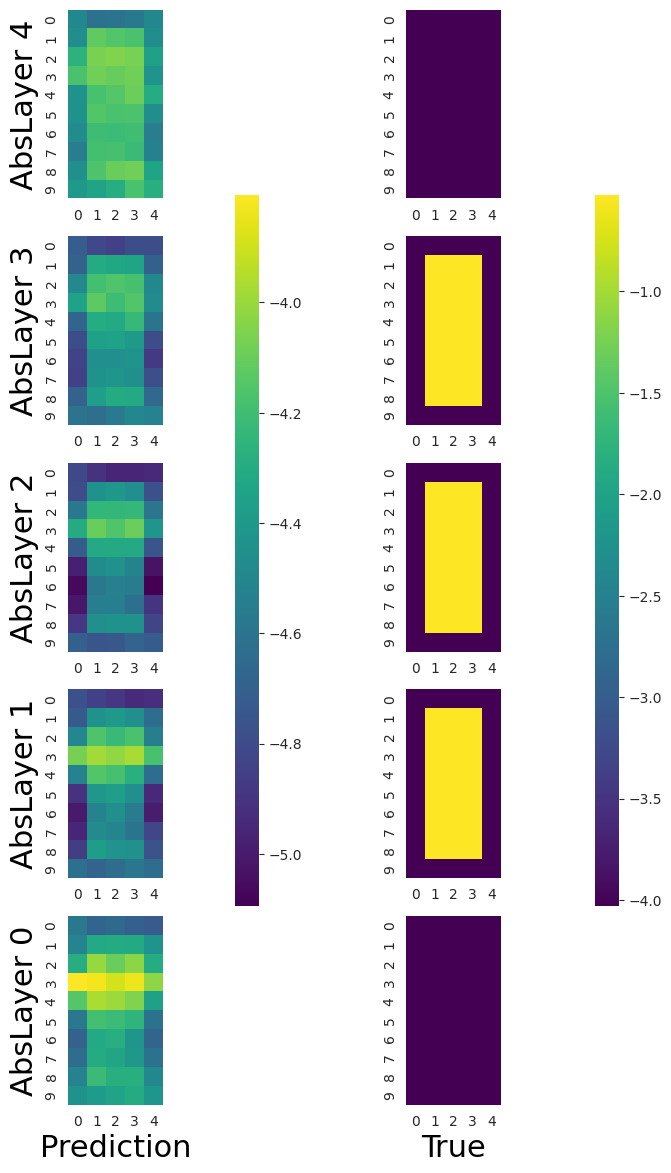

array([[[0.01029863, 0.00928837, 0.00946725, 0.00904852, 0.00883542],
        [0.01100227, 0.01334673, 0.01346888, 0.01340593, 0.01187333],
        [0.01371961, 0.0181281 , 0.01660723, 0.01777089, 0.01358252],
        [0.02227869, 0.02174148, 0.02044304, 0.02159172, 0.01788257],
        [0.01579832, 0.01893538, 0.01838599, 0.01741431, 0.01280251],
        [0.01025909, 0.01512524, 0.01480194, 0.01422053, 0.00993701],
        [0.00918546, 0.01337037, 0.01377662, 0.01199147, 0.00929277],
        [0.00965976, 0.01352681, 0.01308113, 0.01217911, 0.0099629 ],
        [0.01087778, 0.01468305, 0.01386232, 0.01380831, 0.01122019],
        [0.01185915, 0.01239514, 0.0129471 , 0.01349813, 0.01208416]],

       [[0.00839341, 0.00781538, 0.00751356, 0.00716129, 0.00731484],
        [0.00880122, 0.01177978, 0.01229706, 0.01165571, 0.00967392],
        [0.01107201, 0.01554579, 0.0146593 , 0.01539546, 0.01067591],
        [0.01704635, 0.01861296, 0.01794324, 0.0188154 , 0.01532907],
        [0.0107897

In [16]:
import numpy as np
from tomopt.plotting import plot_pred_true_x0
plot_pred_true_x0(np.log(preds[0][0]), np.log(preds[0][1]))
preds[0][0]

1 warmup callbacks found, with a total warmup period of 1 epochs.


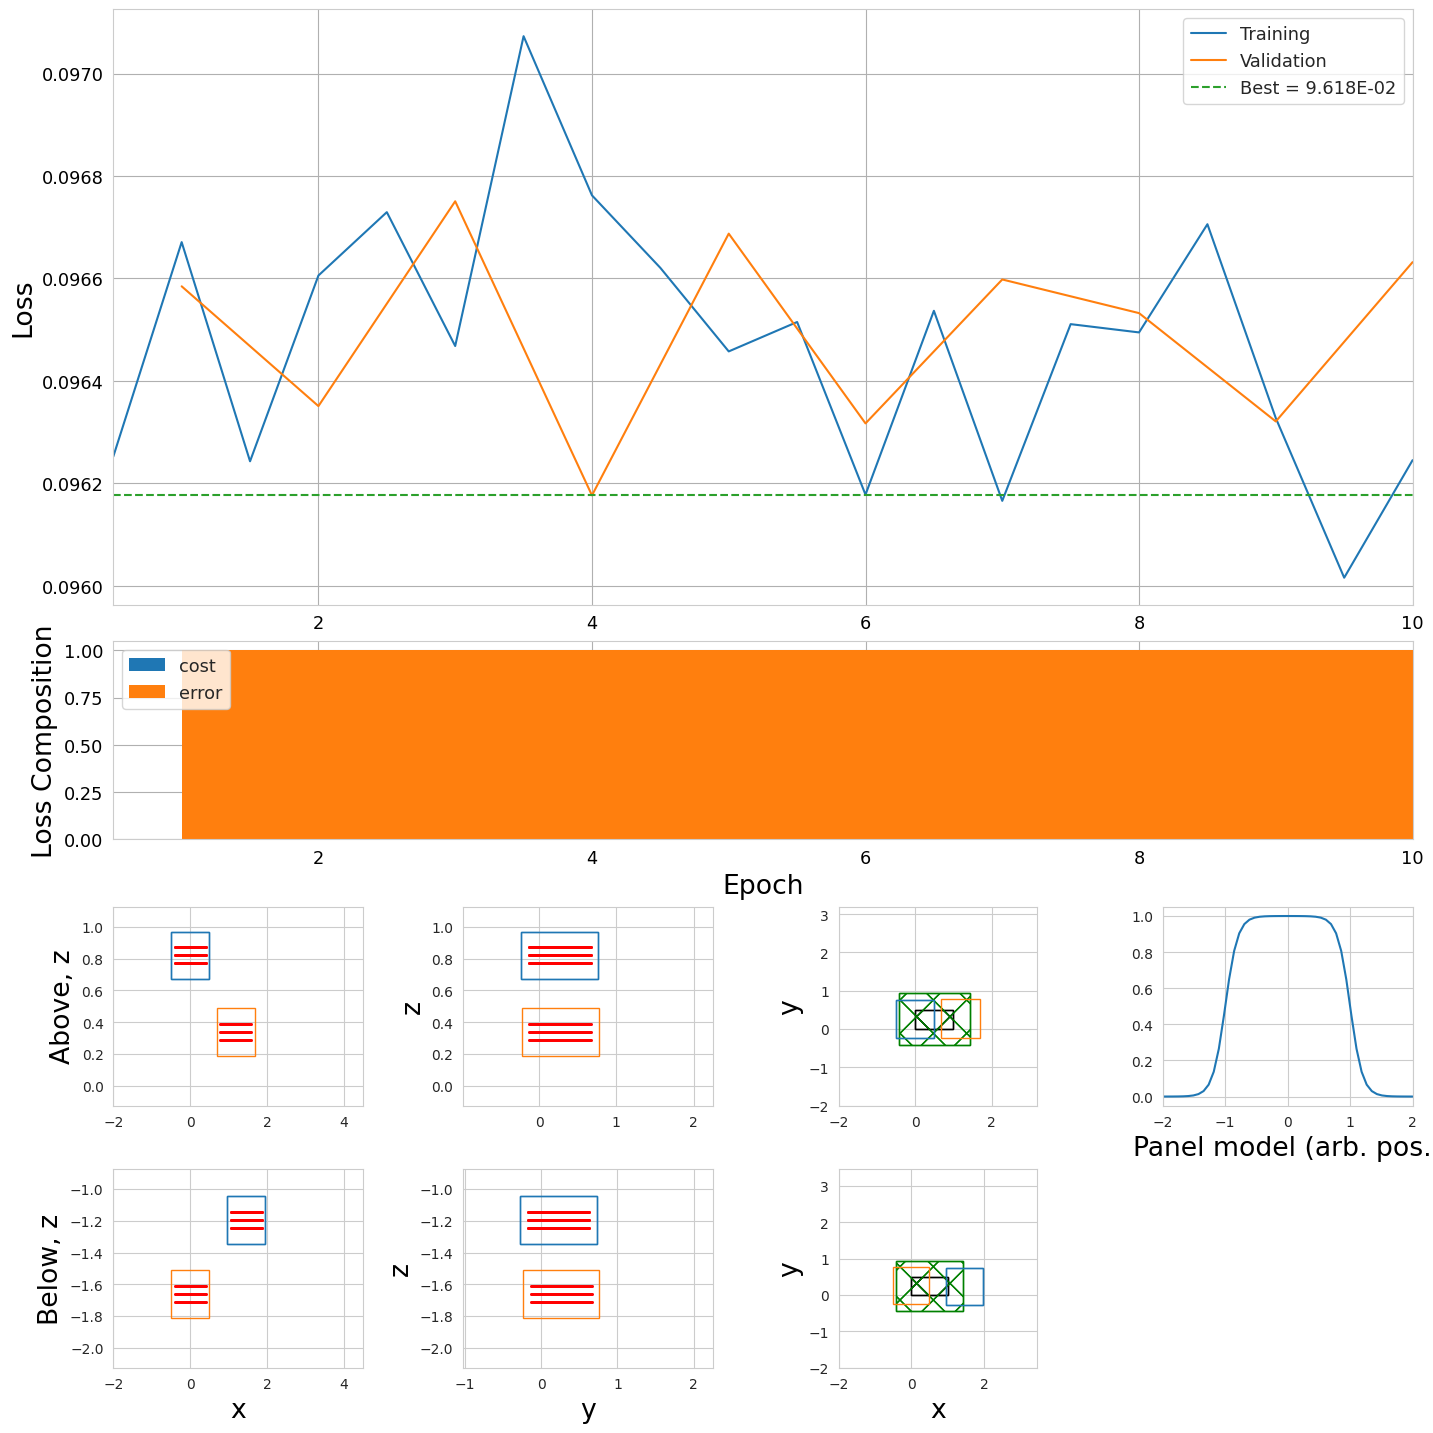

Automatically setting cost coefficient to 0.09625240415334702
OptConfig: Optimiser warm-up completed
+------------+--------------+---------------------+
|   Param    | Median Grad  |          LR         |
+------------+--------------+---------------------+
| xy_pos_opt | 0.0008955265 |  11.166615480972801 |
| z_pos_opt  | 0.012321569  | 0.40579247575090416 |
+------------+--------------+---------------------+


<Figure size 1422.22x1422.22 with 0 Axes>

In [9]:
from tomopt.optimisation import CostCoefWarmup, OptConfig, MuonResampler
from optimisation.hodoscope_callbacks_multilayer import HodoscopeMetricLogger, NoMoreNaNs, HodoscopeUpdateLimiter

_ = wrapper.fit(n_epochs=10,
                passive_bs=1, 
                n_mu_per_volume=1000, 
                mu_bs=250, 
                trn_passives=passives,
                val_passives=passives,  # Evaluate on the training data
                cbs=[OptConfig(n_warmup=1, rates={'xy_pos_opt':0.01, 'z_pos_opt':0.005}),
                    # opt_config,
                       MuonResampler(), NoMoreNaNs(),HodoscopeMetricLogger(),
                         HodoscopeUpdateLimiter()
                         ])

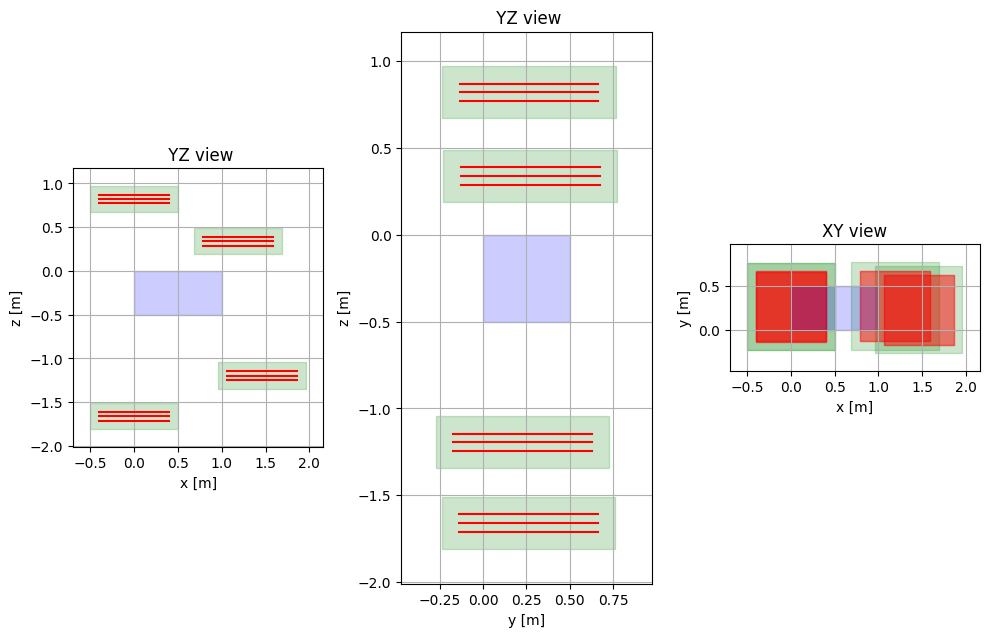

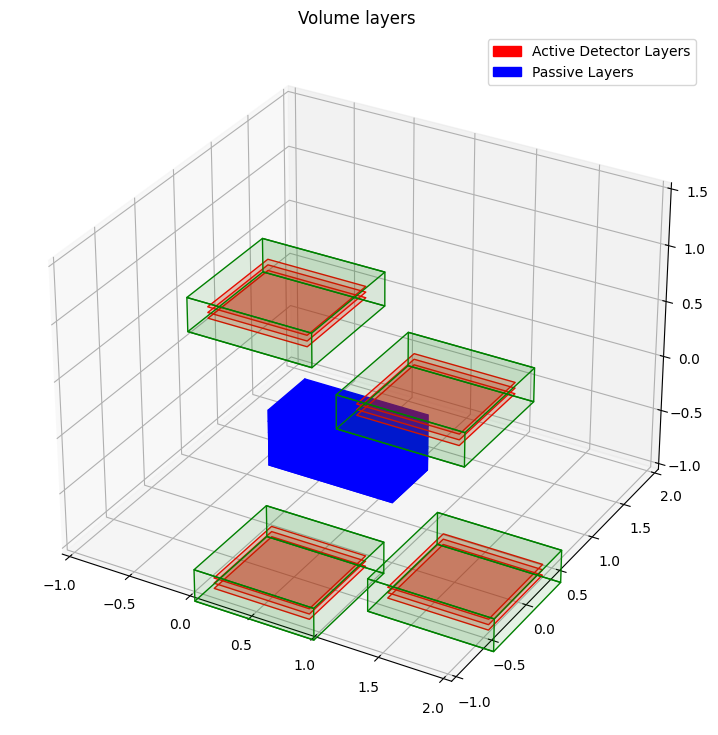

In [10]:
draw_volume_2D(volume)
draw(volume, [-1.,2.], [-1., 2.], [-1.,1.5])

In [12]:
from tomopt.optimisation.callbacks import MuonResampler, ScatterRecord, HitRecord
from tomopt.optimisation import PredHandler, ScatterRecord, HitRecord

sr = ScatterRecord()
hr = HitRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length_cargo]), 
                        n_mu_per_volume=1000, 
                        mu_bs=250, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr])

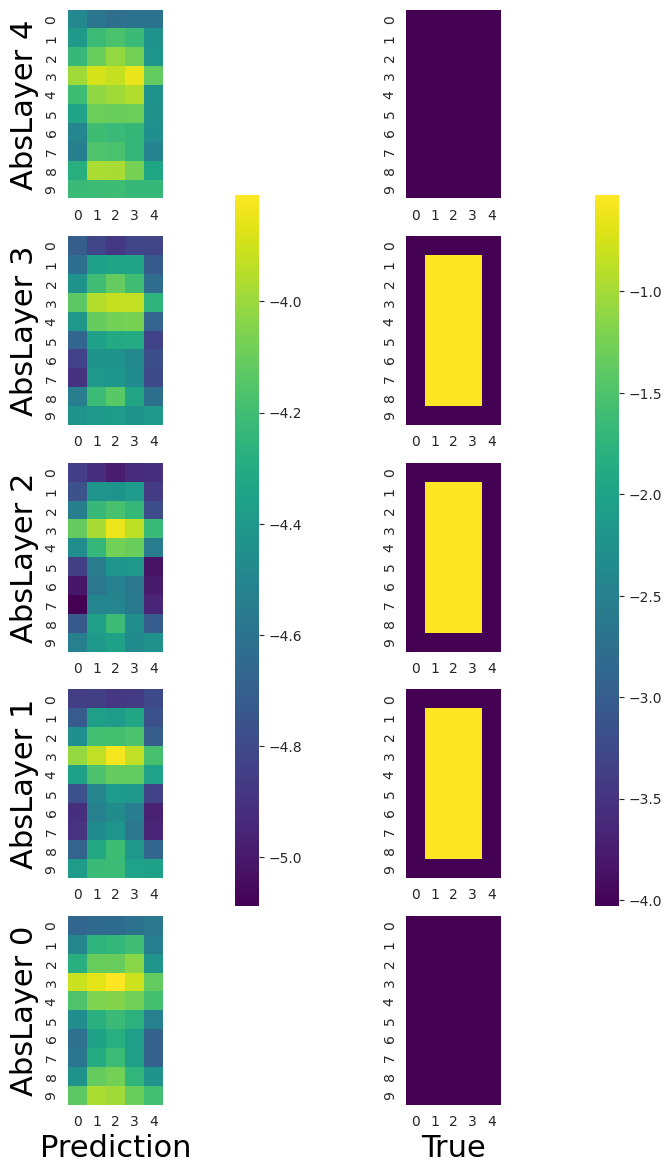

In [14]:
import numpy as np
from tomopt.plotting import plot_pred_true_x0
plot_pred_true_x0(np.log(preds[0][0]), np.log(preds[0][1]))

In [ ]:
zpos= []
for l in wrapper.volume.get_detectors(): 
    for h in l.hodoscopes:
        for p in h.panels:
            zpos.append(p.z)

In [ ]:
def find_equal_pairs(lst):
    n = len(lst)
    for i in range(n):
        for j in range(i + 1, n):
            if torch.abs(lst[i] -  lst[j])<0.01:
                return True, (lst[i], lst[j])
    return False, None

In [ ]:
find_equal_pairs(zpos)

(False, None)